## Problem 3. BiLSTM-CRF (30 points)

In this problem, you are expected to build a BiLSTM-CRF network model for named entity recognition (NER). 
The training, validation and testing datasets are English text, which have been provided below. The labels are tags of words in the text. 

The requirements are:

1)	[10 points] Build a BiLSTM-CRF model. If you use only the LSTM model, you will be given only half of the score. All code should be in the jupyter notebook. 

2)	[5 points] The training module should include training and validation processes. The training and validation batch size should be 32. 

3)	[5 points] Batches should have different max lengths. 

4)	[5 points] Plot the training loss curve and validation loss curve based on each epoch. 

5)	[5 points] Evaluate the test dataset by F1 score. 

Note：You should write comments to explain what you have done for the important parts and why your code works for the above requirements. The given code for data preprocessing should not be changed.

#### Reference: 
A paper for more information about sequence tagging problem and BiLSTM-CRF: https://arxiv.org/pdf/1603.01360.pdf


In [1]:
import pandas as pd
import numpy as np

We use an NER dataset for the training. Here is some preprocessing codes.

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.tail(15)

,Sentence #,Word,Tag
1048560,Sentence: 47958,of,O
1048561,Sentence: 47958,the,O
1048562,Sentence: 47958,rockets,O
1048563,Sentence: 47958,exploded,O
1048564,Sentence: 47958,upon,O
1048565,Sentence: 47958,impact,O
1048566,Sentence: 47958,.,O
1048567,Sentence: 47959,Indian,B-gpe
1048568,Sentence: 47959,forces,O
1048569,Sentence: 47959,said,O


The dataset includes 35178 words and 17 different tags.

In [3]:
word_to_ix = {}
words = set(list(data['Word'].values))
for w in words:
    word_to_ix[w]=len(word_to_ix)
n_words = len(words)
print(n_words)

35178


In [4]:
tag_dicts={}
tags = set(list(data["Tag"].values))
for t in tags:
    tag_dicts[t]=len(tag_dicts)
n_tags = len(tags)
print(n_tags)
print(tag_dicts)

17
{'O': 0, 'B-per': 1, 'I-eve': 2, 'B-art': 3, 'I-nat': 4, 'B-tim': 5, 'I-per': 6, 'B-eve': 7, 'B-org': 8, 'B-geo': 9, 'I-art': 10, 'B-gpe': 11, 'I-gpe': 12, 'I-tim': 13, 'B-nat': 14, 'I-org': 15, 'I-geo': 16}


In [5]:
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
grouped = data.groupby("Sentence #").apply(agg_func)
sentences = [s for s in grouped]
print(sentences[15])

[('Israeli', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('Prime', 'B-per'), ('Minister', 'I-per'), ('Ariel', 'I-per'), ('Sharon', 'I-per'), ('will', 'O'), ('undergo', 'O'), ('a', 'O'), ('medical', 'O'), ('procedure', 'O'), ('Thursday', 'B-tim'), ('to', 'O'), ('close', 'O'), ('a', 'O'), ('tiny', 'O'), ('hole', 'O'), ('in', 'O'), ('his', 'O'), ('heart', 'O'), ('discovered', 'O'), ('during', 'O'), ('treatment', 'O'), ('for', 'O'), ('a', 'O'), ('minor', 'O'), ('stroke', 'O'), ('suffered', 'O'), ('last', 'O'), ('month', 'O'), ('.', 'O')]


We should change the data into a sequence list and a tag list. Besides, we change the words and tags into dictionary indexes, which are easier to feed into the embeding layer.

In [6]:
max_len = 50
X = [[w[0]for w in s] for s in sentences]
Y = [[w[1]for w in s] for s in sentences]
new_data = []
new_tags=[]
for seq,tag in zip(X,Y):
    new_seq=[]
    new_tag=[]
    for i in range(max_len):
        try:
            new_seq.append(word_to_ix[seq[i]])
            new_tag.append(tag_dicts[tag[i]])
        except:
            pass
    new_data.append(new_seq)
    new_tags.append(new_tag)
print(new_data[15])
print(new_tags[15])

[18753, 31720, 20995, 17343, 27887, 18062, 28668, 25674, 26216, 7920, 29906, 20944, 34825, 22081, 26338, 7920, 24284, 17919, 7604, 10808, 68, 9484, 9669, 31870, 32631, 7920, 24865, 6069, 30542, 8904, 21134, 30644]
[11, 0, 0, 1, 6, 6, 6, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, new_tags, test_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3)

### Step1. model building

In [8]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)#设置随机种子
########################################################################################################################
#定义一些工具函数
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
#########################################################################################################################
#建立标准BiLSTM_CRF模型类
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):#文本长度，tag的字典，嵌入向量的维度，lstm的隐层维度
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        #输入为一个编号列表，输出为对应的符号嵌入向量列表（词典的大小尺寸，嵌入向量的维度，即用多少维来表示一个符号）
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_dicts[START_TAG], :] = -10000
        self.transitions.data[:, tag_dicts[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    #根据 随机的transitions ，前向传播算出的一个score，用到了动态规划的思想，但是因为用的是随机的转移矩阵，算出的值很大 score>20
    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)#1*5 而且全是-10000
        # START_TAG has all of the score.
        #因为start tag是4，所以tensor([[-10000., -10000., -10000., 0., -10000.]])，将start的值为零，表示开始进行网络的传播
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas#初始状态的forward_var，随着step t变化

        # Iterate through the sentence会迭代feats的行数次
        for feat in feats:#feat的维度是５ 依次把每一行取出来
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)#维度是1*5，LSTM后的那个矩阵，就被当做是emit score（指真实标签对应的那个score）了
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    #函数里经过了embedding，lstm，linear层，是根据LSTM算出的一个矩阵。
    #这里是11x5的一个tensor，而这个11x5的tensor，就是发射矩阵（emission matrix）
    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    #根据真实的标签算出的一个score
    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    #维特比解码，实际上就是在预测的时候使用了，输出得分与路径值
    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)#11*5 经过了LSTM+Linear矩阵后的输出，之后作为CRF的输入。
        forward_score = self._forward_alg(feats)#0维的一个得分，20.*
        gold_score = self._score_sentence(feats, tags)#tensor([ 4.5836])
        return forward_score - gold_score#这是两者之间的差值，后来直接根据这个差值，反向传播。

    def forward(self, sentence):  # dont confuse this with _forward_alg above.forward函数只是用来预测了，train的时候没用调用它
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

### Step2. training module

  0%|                                                                                          | 0/735 [00:00<?, ?it/s]

(tensor(49.5800), [0, 13, 11, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 2, 16])


d:\anaconda3\envs\cs286\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|████████████████████████████████████████████████████████████████████████████████| 315/315 [08:16<00:00,  1.57s/it]


(tensor(205.8082), [0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0])


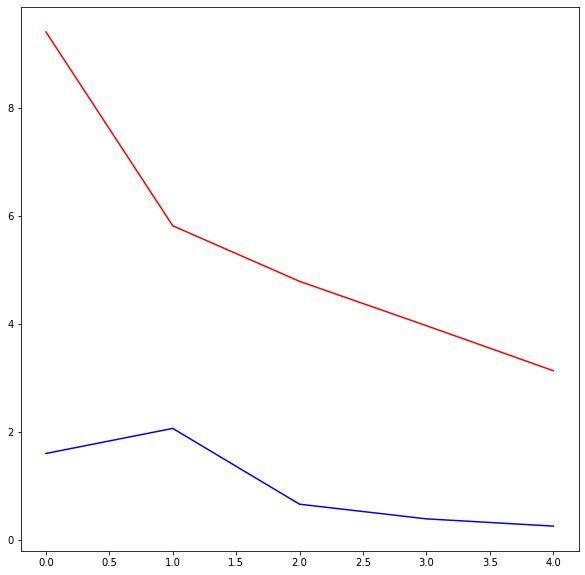

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt
START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5
HIDDEN_DIM = 4
batch_size=32
train_loss=[]
valid_loss=[]
train_loss_sum=[]
valid_loss_sum=[]

#生成每个batch
def get_batch(dataset1,dataset2, batch_size):
    lens = len(dataset1)
    batch = lens//batch_size #看看能分成多个满足batchsize的整份,可能有余数
    remain = lens%batch_size #看余数
    result1=[]
    result2=[]
    for i in range(batch):
        result1.append(dataset1[0 + (i*batch_size):batch_size + (i*batch_size)])
        result2.append(dataset2[0 + (i*batch_size):batch_size + (i*batch_size)])
    else:
        result1.append(dataset1[-remain:])
        result2.append(dataset2[-remain:]) #返回剩下的
    return result1,result2


#准备数据
# X_train_b,y_train_b = get_batch(X_train[:100],y_train[:100], batch_size)#可在此处调整训练集大小
X_train_b,y_train_b = get_batch(X_train,y_train, batch_size)#可在此处调整训练集大小
X_valid_b,y_valid_b=get_batch(X_valid,y_valid,batch_size)
tag_dicts[START_TAG]=17
tag_dicts[STOP_TAG]=18




#实例化模型和优化器
model = BiLSTM_CRF(len(word_to_ix), tag_dicts, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check predictions before training
with torch.no_grad():
    precheck_sent = prepare_sequence(X[0], word_to_ix)
    precheck_tags = torch.tensor([tag_dicts[t] for t in Y[0]], dtype=torch.long)
    print(model(precheck_sent))

    
#训练和验证
for epoch in range(
        5):  # again, normally you would NOT do 300 epochs, it is toy data
    for i in tqdm(range(len(X_train_b))):#训练batch
        train_loss=[]
        train_data_b=X_train_b[i]
        train_label_b=y_train_b[i]     
        for (sentence, tags) in zip(train_data_b,train_label_b):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()
            # Step 2. Get our inputs ready for the network, that is,
            # turn them into Tensors of word indices.
#             sentence_in = prepare_sequence(sentence, word_to_ix)
            sentence_in=torch.tensor(sentence,dtype=torch.long)
            targets = torch.tensor(tags, dtype=torch.long)
            # Step 3. Run our forward pass.
            loss = model.neg_log_likelihood(sentence_in, targets)#tensor([ 15.4958]) 最大的可能的值与根据随机转移矩阵计算的真实值的差
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss.backward()#进行了反向传播，算了梯度值。debug中可以看到，transition的_grad 有了值 torch.Size([5, 5])
            optimizer.step()        
        loss=loss.float()
#         print('loss.shape:',loss.shape)
        train_loss.append(loss)
    train_loss_sum.append(torch.mean(torch.tensor(train_loss)))
    for i in tqdm(range(len(X_valid_b))):#验证batch
        valid_loss=[]
        valid_data_b=X_valid_b[i]
        valid_label_b=y_valid_b[i]   
        for (sen_v,tags_v) in zip(valid_data_b,valid_label_b):
            sentence_in_v=torch.tensor(sen_v,dtype=torch.long)
            targets_v = torch.tensor(tags_v, dtype=torch.long)
            loss_v=model.neg_log_likelihood(sentence_in_v, targets_v)
        loss_v=loss_v.float()
        valid_loss.append(loss_v)
    valid_loss_sum.append(torch.mean(torch.tensor(valid_loss)))

# Check predictions after training
with torch.no_grad():
    precheck_sent = prepare_sequence(X[0], word_to_ix)
    print(model(precheck_sent))
    
    

torch.save(model,'BiLSTM_CRF.pkl')




%matplotlib inline
figure1=plt.figure(figsize=(10,10))
plt.plot(train_loss_sum,'b',valid_loss_sum,'r')
plt.show()
    

### Step3. test module

14388it [05:14, 45.77it/s]


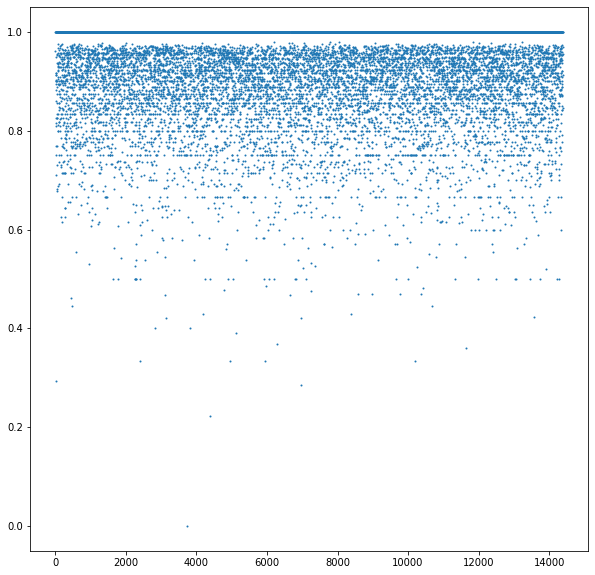

F1_score: 0.9142976083792527


In [10]:
from sklearn.metrics import f1_score
model=torch.load('BiLSTM_CRF.pkl')
test_loss=[]
f1=[]
y_true=[]
y_pred=[]
# for (sen_t,tags_t) in tqdm(zip(X_test[:100],y_test[:100])):#此处修改测试数据大小
for (sen_t,tags_t) in tqdm(zip(X_test,y_test)):#此处修改测试数据大小
    sentence_in_t=torch.tensor(sen_t,dtype=torch.long)
    targets_t = torch.tensor(tags_t, dtype=torch.long)
    score,tag_seq=model.forward(sentence_in_t)
    y_true+=targets_t
    y_pred+=tag_seq
    f1_micro = f1_score(targets_t,tag_seq,average='micro')
    f1.append(f1_micro)
figure1=plt.figure(figsize=(10,10))
plt.scatter([i for i in range(len(f1))],f1,1)
plt.show()
F1=f1_score(y_true,y_pred,average='micro')
print('F1_score:',F1)